In [14]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
print("Project root added to sys.path")

Project root added to sys.path


In [2]:
from utils.data_loader import load_dataset
from utils.data_partition import (
    iid_partition,
    non_iid_partition,
    dirichlet_partition,
    quantity_skew_partition,
    temporal_partition,
    hybrid_partition,
)
from clients.aggregators import avg_aggregate
from clients.federated_training import federated_training

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
dataset_name = "mnist"
num_clients = 5
rounds = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
trainset, testset = load_dataset(dataset_name)

[INFO] Loaded dataset 'mnist' with 60000 training samples and 10000 testing samples.


In [5]:
partitions = {
    "iid":            iid_partition(trainset, num_clients),
    "non_iid":        non_iid_partition(trainset, num_clients=num_clients, num_shards=10),
    "dirichlet":      dirichlet_partition(trainset, num_clients=num_clients, alpha=0.5),
    "quantity_skew":  quantity_skew_partition(trainset, num_clients=num_clients),
    "temporal":       temporal_partition(trainset, num_clients=num_clients),
    "hybrid":         hybrid_partition(trainset, num_clients=num_clients, alpha=0.5),
}

print("Partitions created:", list(partitions.keys()))

Partitions created: ['iid', 'non_iid', 'dirichlet', 'quantity_skew', 'temporal', 'hybrid']


c:\Users\la7tim\Desktop\Internship\FedTinyProp\utils\data_partition.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(dataset.targets)


c:\Users\la7tim\Desktop\Internship\FedTinyProp\utils\partitions_visualization.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(dataset.targets)[indices]


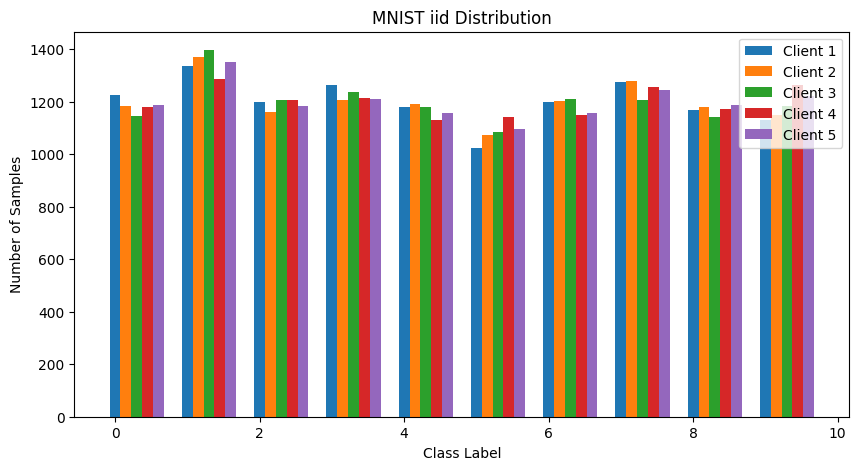

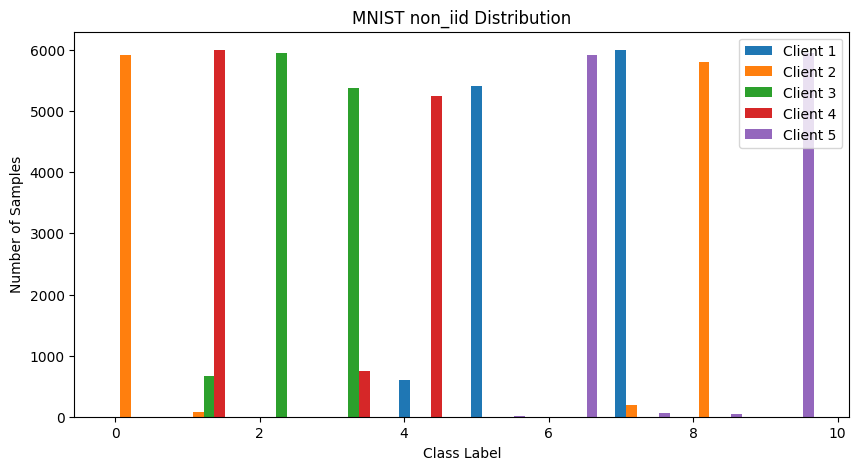

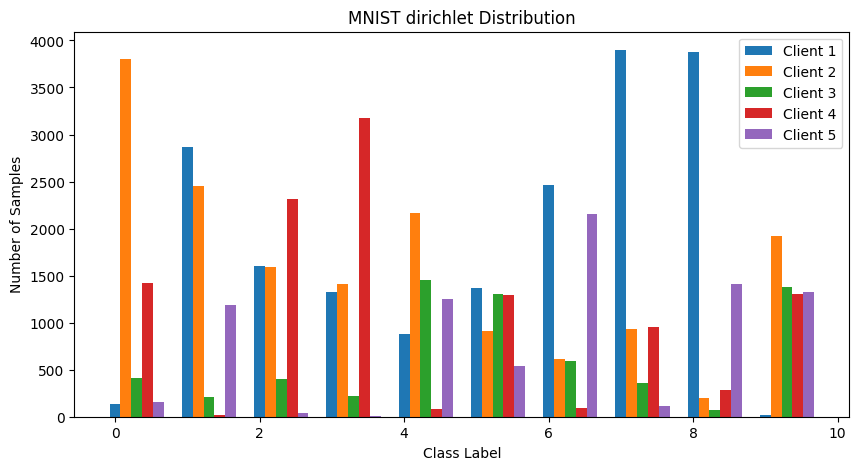

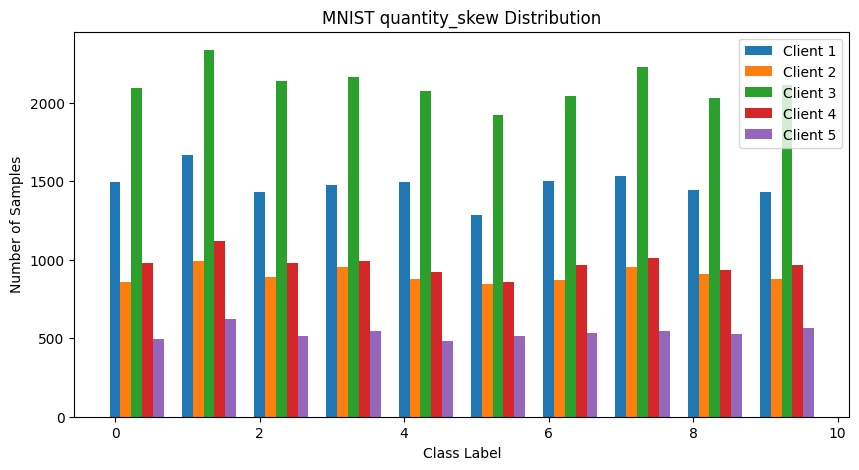

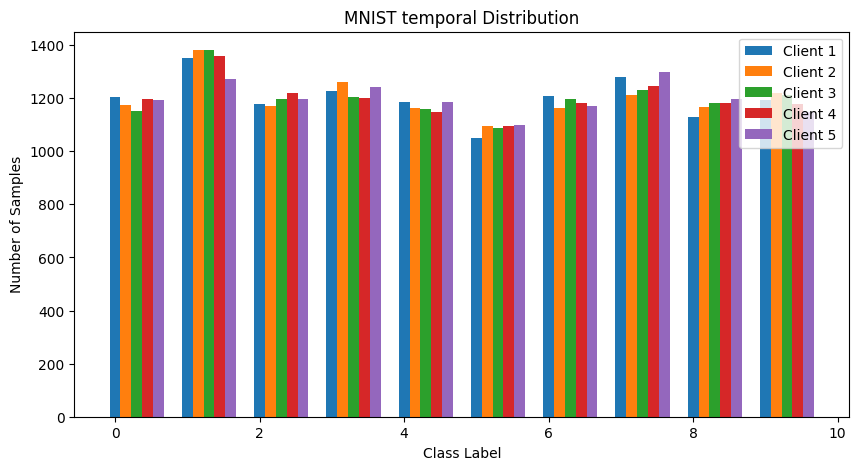

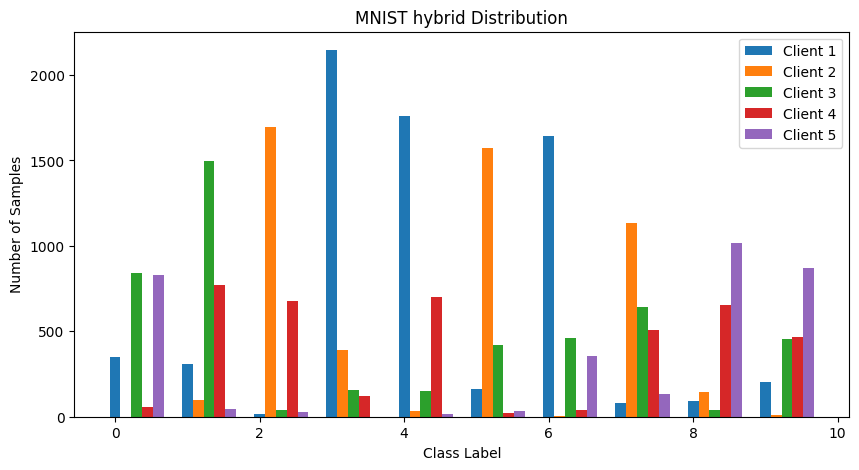

In [11]:
from utils.partitions_visualization import plot_class_distribution

for name, subsets in partitions.items():
    plot_class_distribution(subsets, trainset, f"MNIST {name} Distribution", num_classes=10)

In [6]:
from models.tinyProp import TinyPropParams
tinyprop_params = TinyPropParams(S_min=0.05, S_max=0.5, zeta=0.25, number_of_layers=2)

all_results = {}

In [9]:
for strategy, subsets in partitions.items():
    print(f"\n=== Federated Training with {strategy.upper()} partitions ===")

    global_model, acc_list, flops_list, mem_list, comm_list, sparsity_list = federated_training(
        client_datasets=subsets,
        model_name=dataset_name,
        testset=testset,
        tinyprop_params=tinyprop_params,
        aggregator_fn=avg_aggregate,  
        aggregator_kwargs=None,
        rounds=rounds,
        device=device,
        local_epochs=1,    
        visualize=False     
    )

    final_acc     = acc_list[-1]          if acc_list      else 0
    final_flops   = flops_list[-1]        if flops_list    else 0
    final_mem     = mem_list[-1]          if mem_list      else 0
    final_comm    = comm_list[-1]         if comm_list     else 0
    final_spars   = sparsity_list[-1]     if sparsity_list else 0

    print(f"[{strategy.upper()}] Final Accuracy: {final_acc:.4f}")
    print(f"[{strategy.upper()}] Final FLOPs:    {final_flops:.2f}")
    print(f"[{strategy.upper()}] Final Memory:   {final_mem:.2f} bytes")
    print(f"[{strategy.upper()}] Final Comm:     {final_comm:.2f} bytes")
    print(f"[{strategy.upper()}] Final Sparsity: {final_spars*100:.2f}%")

    all_results[strategy] = {
        "acc": acc_list,
        "flops": flops_list,
        "mem": mem_list,
        "comm": comm_list,
        "sparsity": sparsity_list
    }

print("\nDone!\n")



=== Federated Training with IID partitions ===

Round 1/10
Test Accuracy: 0.6590
[Compute] round_flops=257687249.65, [Mem] peak=4282900.0 bytes, [Comm] 1675717508.0 bytes, [Sparsity] 13.74%

Round 2/10
Test Accuracy: 0.9758
[Compute] round_flops=181700844.18, [Mem] peak=1638700.0 bytes, [Comm] 1181584600.0 bytes, [Sparsity] 9.69%

Round 3/10
Test Accuracy: 0.9815
[Compute] round_flops=112993983.62, [Mem] peak=1043928.0 bytes, [Comm] 734789932.0 bytes, [Sparsity] 6.03%

Round 4/10
Test Accuracy: 0.9848
[Compute] round_flops=84716870.23, [Mem] peak=738412.0 bytes, [Comm] 550906352.0 bytes, [Sparsity] 4.52%

Round 5/10
Test Accuracy: 0.9845
[Compute] round_flops=74112163.90, [Mem] peak=791236.0 bytes, [Comm] 481944880.0 bytes, [Sparsity] 3.95%

Round 6/10
Test Accuracy: 0.9861
[Compute] round_flops=63720382.50, [Mem] peak=651808.0 bytes, [Comm] 414368040.0 bytes, [Sparsity] 3.40%

Round 7/10
Test Accuracy: 0.9859
[Compute] round_flops=58479259.14, [Mem] peak=591176.0 bytes, [Comm] 380285

RuntimeError: selected index k out of range

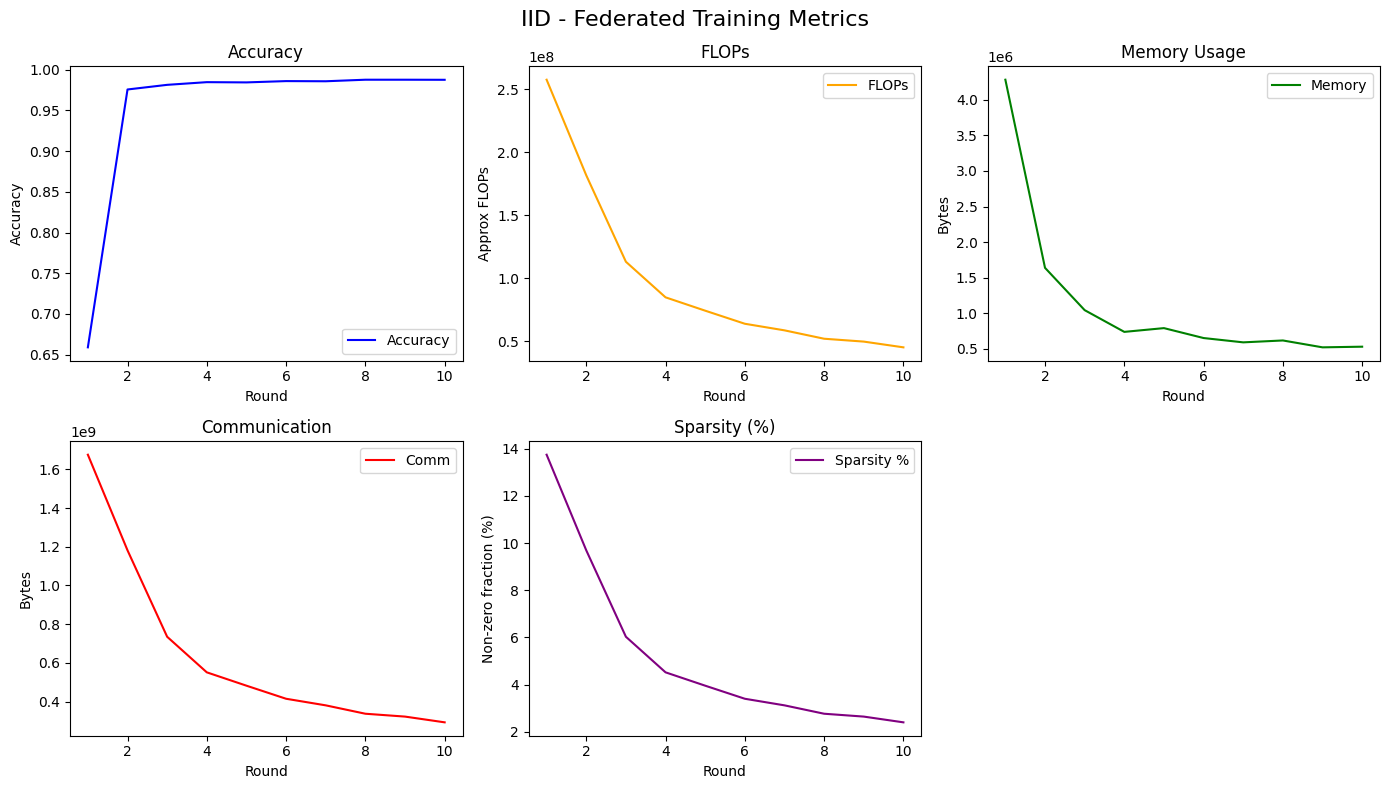

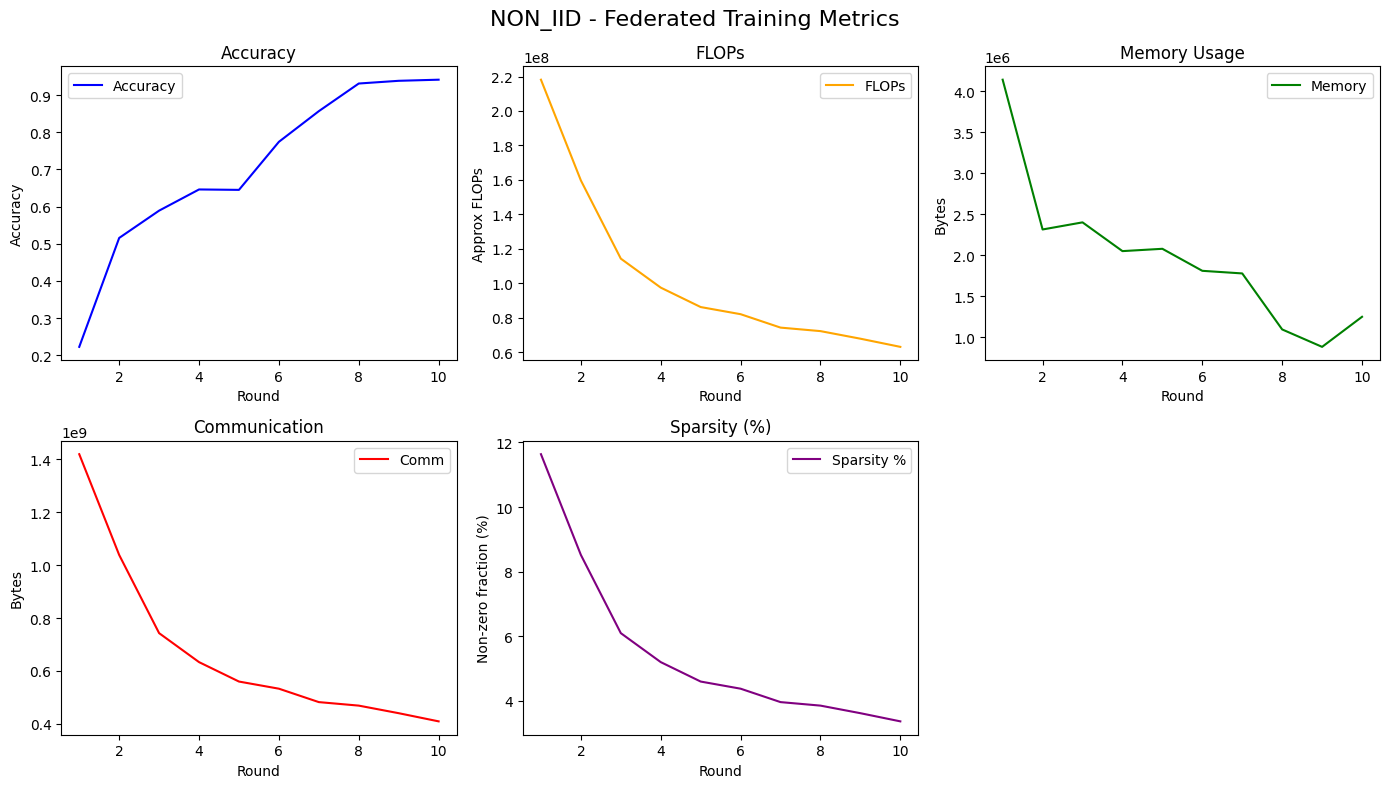

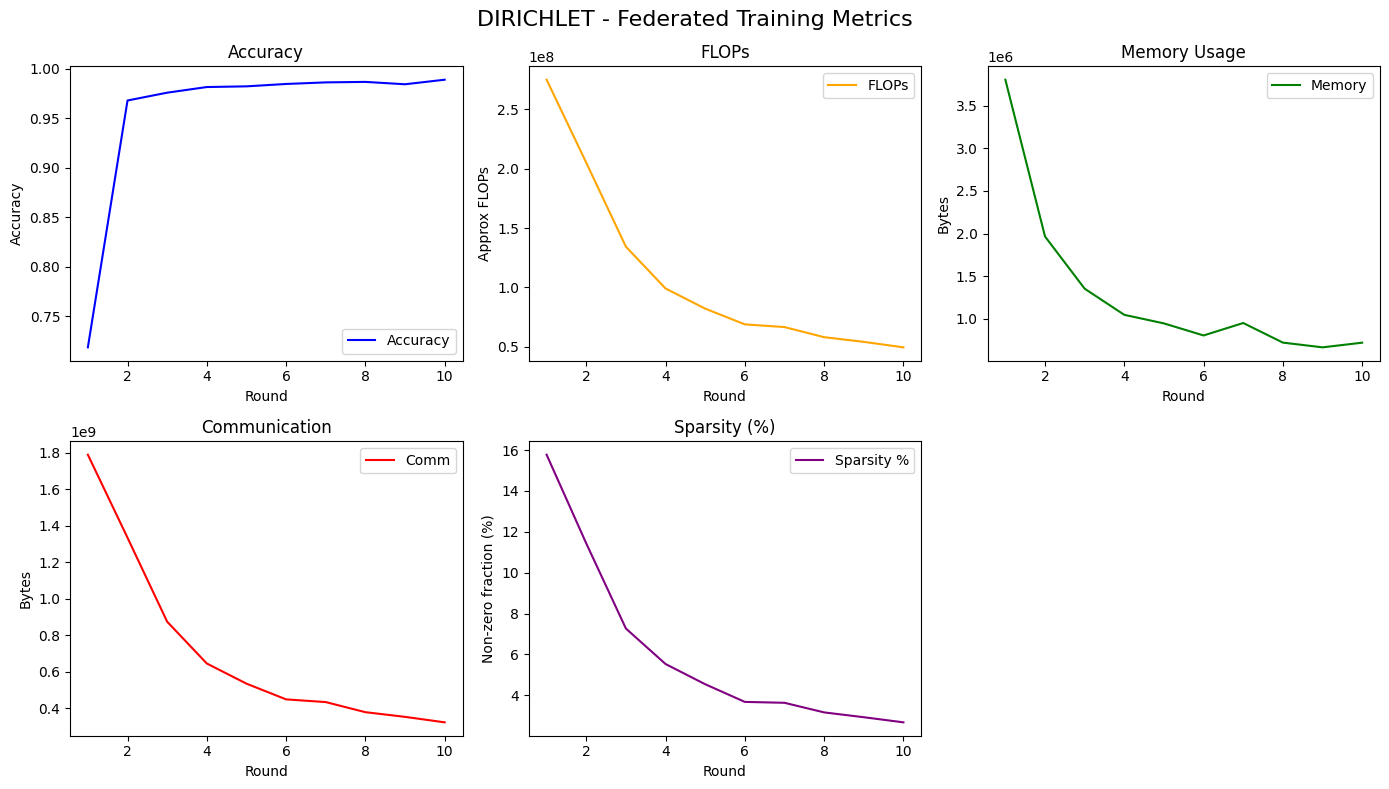

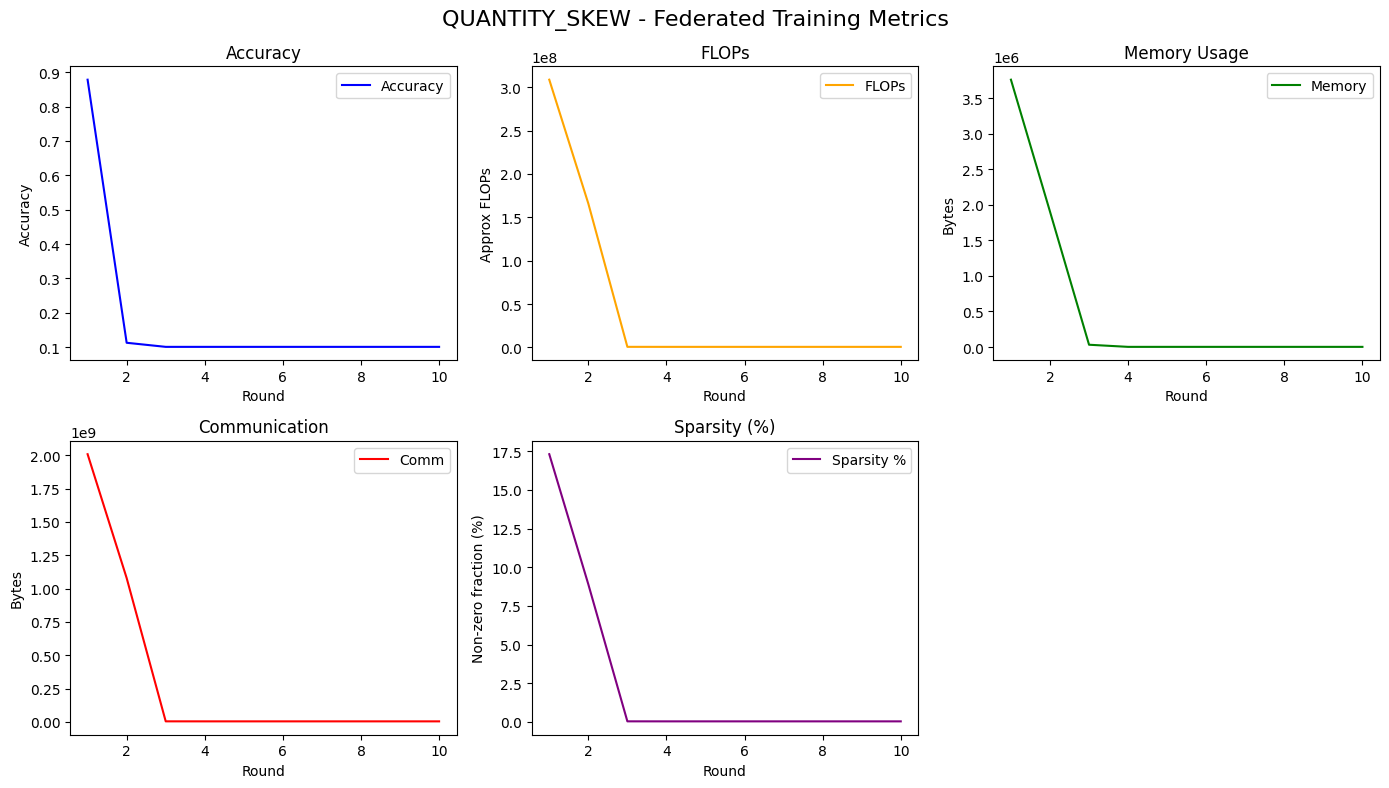

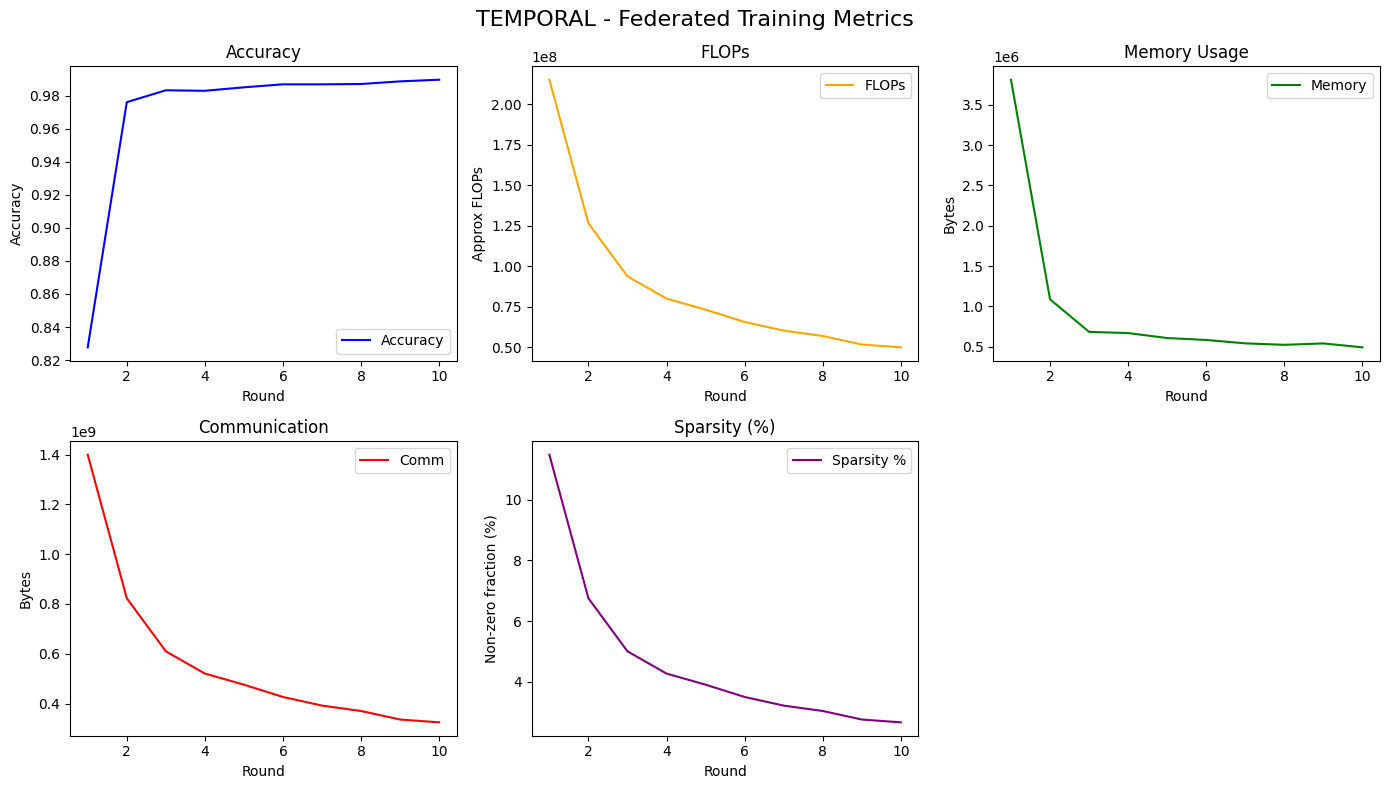

In [ ]:
import matplotlib.pyplot as plt

for strategy, metrics in all_results.items():
    rounds_axis = range(1, len(metrics["acc"])+1)
    
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle(f"{strategy.upper()} - Federated Training Metrics", fontsize=16)

    # 1) Accuracy
    axs[0, 0].plot(rounds_axis, metrics["acc"], label="Accuracy", color='blue')
    axs[0, 0].set_title("Accuracy")
    axs[0, 0].set_xlabel("Round")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].legend()

    # 2) FLOPs
    axs[0, 1].plot(rounds_axis, metrics["flops"], label="FLOPs", color='orange')
    axs[0, 1].set_title("FLOPs")
    axs[0, 1].set_xlabel("Round")
    axs[0, 1].set_ylabel("Approx FLOPs")
    axs[0, 1].legend()

    # 3) Memory
    axs[0, 2].plot(rounds_axis, metrics["mem"], label="Memory", color='green')
    axs[0, 2].set_title("Memory Usage")
    axs[0, 2].set_xlabel("Round")
    axs[0, 2].set_ylabel("Bytes")
    axs[0, 2].legend()

    # 4) Communication
    axs[1, 0].plot(rounds_axis, metrics["comm"], label="Comm", color='red')
    axs[1, 0].set_title("Communication")
    axs[1, 0].set_xlabel("Round")
    axs[1, 0].set_ylabel("Bytes")
    axs[1, 0].legend()

    # 5) Sparsity
    if "sparsity" in metrics:
        sps = [s * 100 for s in metrics["sparsity"]]
        axs[1, 1].plot(rounds_axis, sps, label="Sparsity %", color='purple')
        axs[1, 1].set_title("Sparsity (%)")
        axs[1, 1].set_xlabel("Round")
        axs[1, 1].set_ylabel("Non-zero fraction (%)")
        axs[1, 1].legend()
    else:
        axs[1, 1].set_title("No Sparsity Data")
        axs[1, 1].axis('off')

    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [17]:
import matplotlib.pyplot as plt

def plot_all_partitions_in_one_figure(all_results):


    metric_keys = ["acc", "flops", "mem", "comm", "sparsity"]
    metric_titles = ["Accuracy", "FLOPs", "Memory", "Communication", "Sparsity"]
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Federated Training Metrics by Partition Strategy", fontsize=16)
    axs_flat = axs.ravel()

    for i, key in enumerate(metric_keys):
        ax = axs_flat[i]  
        ax.set_title(metric_titles[i])
        for strategy, data in all_results.items():
            if key not in data:
                continue 

            y_values = data[key]
            rounds_axis = range(1, len(y_values) + 1)

            if key == "sparsity":
                y_values = [val * 100 for val in y_values]
            ax.plot(rounds_axis, y_values, label=strategy)

        ax.set_xlabel("Round")
        if key == "acc":
            ax.set_ylabel("Accuracy")
        elif key == "flops":
            ax.set_ylabel("Approx FLOPs")
        elif key == "mem":
            ax.set_ylabel("Memory (bytes)")
        elif key == "comm":
            ax.set_ylabel("Comm (bytes)")
        elif key == "sparsity":
            ax.set_ylabel("Non-zero fraction (%)")

        ax.legend()

    axs_flat[-1].axis("off")

    plt.tight_layout()
    plt.show()


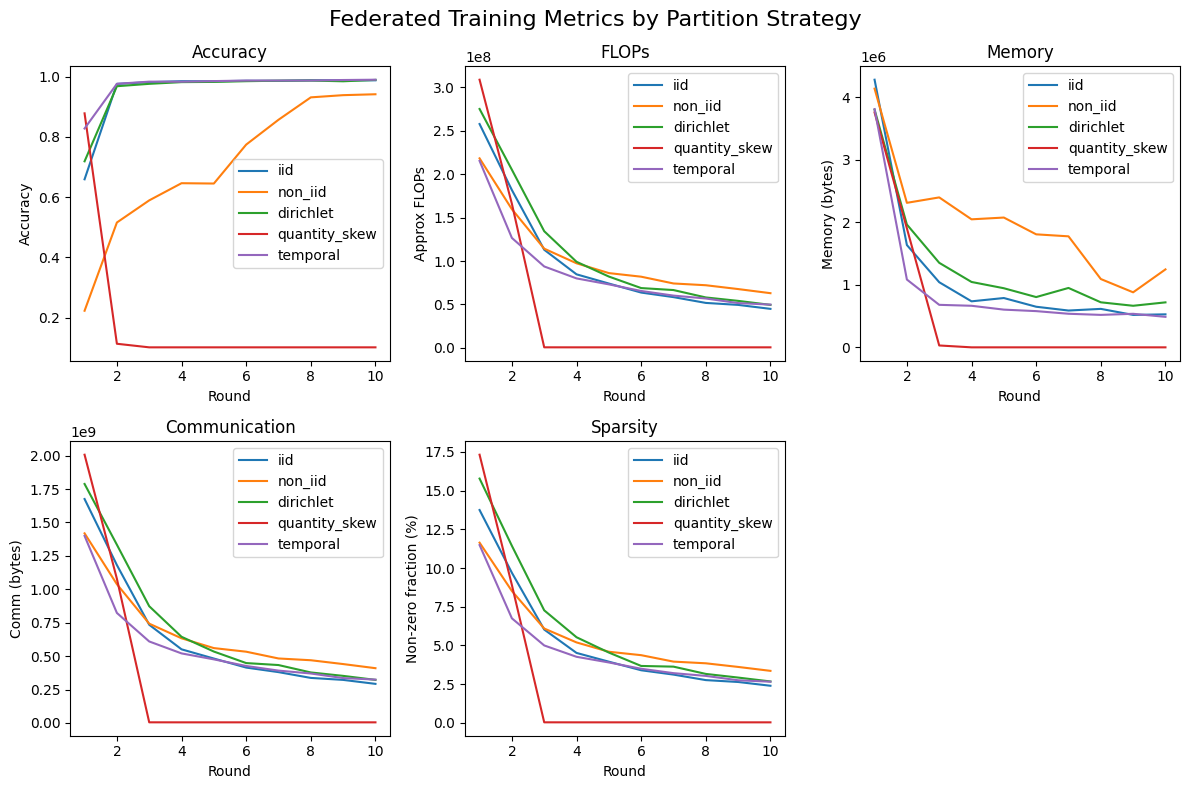

In [18]:
plot_all_partitions_in_one_figure(all_results)